In [1]:
import datetime
import pandas as pd
import multiprocessing as mp
from matplotlib import pyplot as plt

# Get data from gitter and save the dataset (Optional)

In [ ]:
from gitter.scraper import GitterScraper
from gitter.processing.parallel import parallelize

from gitter.preprocessing.messages import apply_messages_pre_processing, process_messages

try:
    scraper = GitterScraper(
        "62fe76c279230fbd70415c924fef5d1b26f1aec7", "555f74e315522ed4b3e0ce42"
    )
    messages = scraper.get_messages(20, 20)

except ValueError:
    print(f'Error with gitter API')

# Create Dataframe
remove_columns = ["text", "status", "v", "editedAt",
                    "threadMessageCount", "readBy", "unread"]

messages_df = pd.DataFrame(process_messages(messages)).drop(
    columns=remove_columns, errors="ignore")

messages_df.rename(columns={'html': 'sentence'}, inplace=True)

if __name__ == '__main__':
    print('Init apply_messages_pre_processing: ')
    messages_df = parallelize(
        messages_df, apply_messages_pre_processing)

    messages_df.head(5)

# messages_df.to_csv('./data/dataset.csv')

# Load dataset and apply sentiment analysis (Optional)

In [ ]:
from gitter.processing.sentence import apply_sentimental_analysis

messages_df = pd.read_csv('./data/dataset.csv') # 5k messages

if __name__ == '__main__':
    print('Init apply_sentimental_analysis: ')
    result_df = parallelize(messages_df, apply_sentimental_analysis)

    # result_df.to_csv('./data/result_dataset.csv', index=False)

    result_df.head(20)


# Load dataset with sentiment analysis

and config sobre tools to pre processing data

In [12]:
from sklearn.preprocessing import MinMaxScaler

messages_df = pd.read_csv('./data/result_dataset.csv')

messages_df['sent'] = pd.to_datetime(pd.to_datetime(messages_df['sent']).dt.date)

scaler = MinMaxScaler()

messages_df.head(5)

,id,sentence,sent,sentiment_label,sentiment,pos,neg
0,626ad3ec41f4560c6f7670bd,bow you might want to move to discord for futu...,2022-04-28,slightly_positive,pos,0.858679,0.141321
1,626ad3f0949ae94006807120,this channel is pretty much dead,2022-04-28,slightly_negative,neg,0.340104,0.659896
2,626ad444fa846847c93e1d4a,also: don't use as a type. it has really unin...,2022-04-28,slightly_positive,pos,0.729082,0.270918
3,626bc3bc61f5ca3feeda20d5,is there a convention for variable / functions...,2022-04-29,positive,pos,0.947884,0.052116
4,626be82fcd938f6ea22273be,what kind of convention,2022-04-29,neutral,neg,0.404834,0.595166


# Prepare dataframes for plot

In [26]:
positive_messages_count_df = messages_df[messages_df.sentiment == 'pos'].groupby(
    ['sent'])['sentiment'].count()

negative_messages_count_df = messages_df[messages_df.sentiment == 'neg'].groupby(
    ['sent'])['sentiment'].count()

messages_testzada = messages_df.groupby(['sent', 'sentiment_label'])[
    'sentiment_label'].count().reset_index(name="count")

# Fequency
frequency_df = messages_df.groupby(
    messages_df['sent'])['sentence'].count().to_frame('count').reset_index()

# Normalization
frequency_df['count'] = pd.DataFrame(scaler.fit_transform(
    frequency_df['count'].values.reshape(-1, 1)))

print(frequency_df.head())

# Sentiment
sentiment_df = messages_df.groupby(messages_df['sent'])[
    'pos'].mean().to_frame('pos').reset_index()


        sent     count
0 2021-05-04  0.174468
1 2021-05-05  0.025532
2 2021-05-06  0.025532
3 2021-05-07  0.000000
4 2021-05-09  0.004255


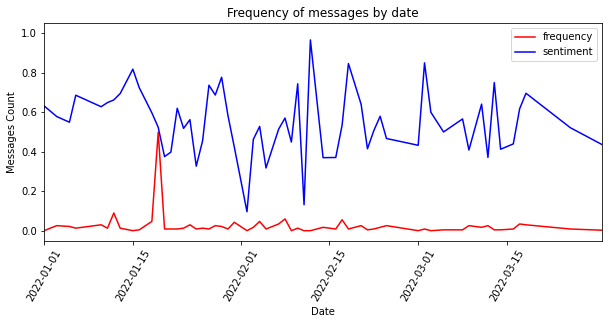

In [27]:
plt.figure(figsize=(10, 4))

# Plotting both the curves simultaneously
plt.plot(frequency_df['sent'],
         frequency_df['count'], color='r', label='frequency')
plt.plot(sentiment_df['sent'],
         sentiment_df['pos'], color='b', label='sentiment')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Messages Count")
plt.title("Frequency of messages by date")
plt.xticks(rotation=60)

plt.xlim(datetime.date(2022, 1, 1), datetime.date(2022, 3, 30))

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()


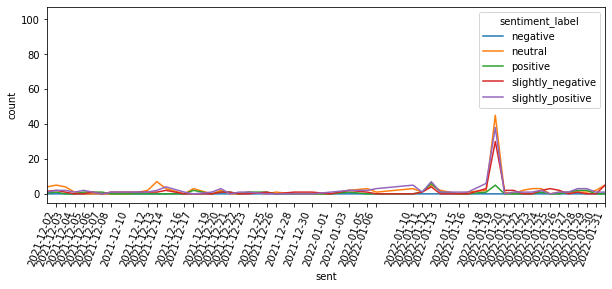

In [7]:
table = pd.pivot_table(messages_testzada, values='count', index=['sent'], columns=['sentiment_label'], fill_value=0)

ax = table.plot(xticks=table.index, ylabel='count',figsize=(10,4), rot=70, xlim=[datetime.date(2021, 12, 1), datetime.date(2022, 1, 31)])